# Implementing a Neural Network for CIFAR dataset
In this exercise, you should change H.W_1 to work on the CIFAR dataset.

CIFAR is a dataset that consists of 60,000 32x32 colour images in 10 classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck), with 6000 images per class.

We will have the same components as were in the previous exercise:
- Loading the data and visualize some of the images
- Training the model. Instead of loading a pre-trained model, we will define a new very basic architecture.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms

## 1) Loading CIFAR dataset (10 points)

You should load the CIFAR dataset. You can use [the pytorch CIFAR tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html). As was done in the previous exercise, you should define a dictionary of ``dataloaders``. For now, no need to define pre-process to the data.
Please stick to the API of H.W_1, create a dataloaders disctionary ``{'train','val'}``

You can use batch_size = 128

In [2]:
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
### Enter you code here

transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

dataloaders = {
    'train': torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)
  }

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Check for the availability of a GPU, and use CPU otherwise
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# for mac
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

**If you manage to load the CIFAR data correctly, you should run the next three cells and see some of the images.**

## Visualize some of the training images

In this dataset the size of the images are 32x32.

It is important to visualize the data in order to see that we load them correctly (maybe we need to divide by 255? should we make channel permutations?)

The code below was taken from H.W_1

In [4]:
inputs, classes = next(iter(dataloaders['train']))
inputs = inputs[0:16]
classes = classes[0:16]

In [5]:
import numpy as np
import matplotlib.pyplot as plt
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    fig = plt.figure(figsize=(5,3), dpi=300)
    plt.imshow(inp)
    if title is not None:
       plt.title(title, fontsize=5)
    plt.pause(0.001)  # pause a bit so that plots are updated

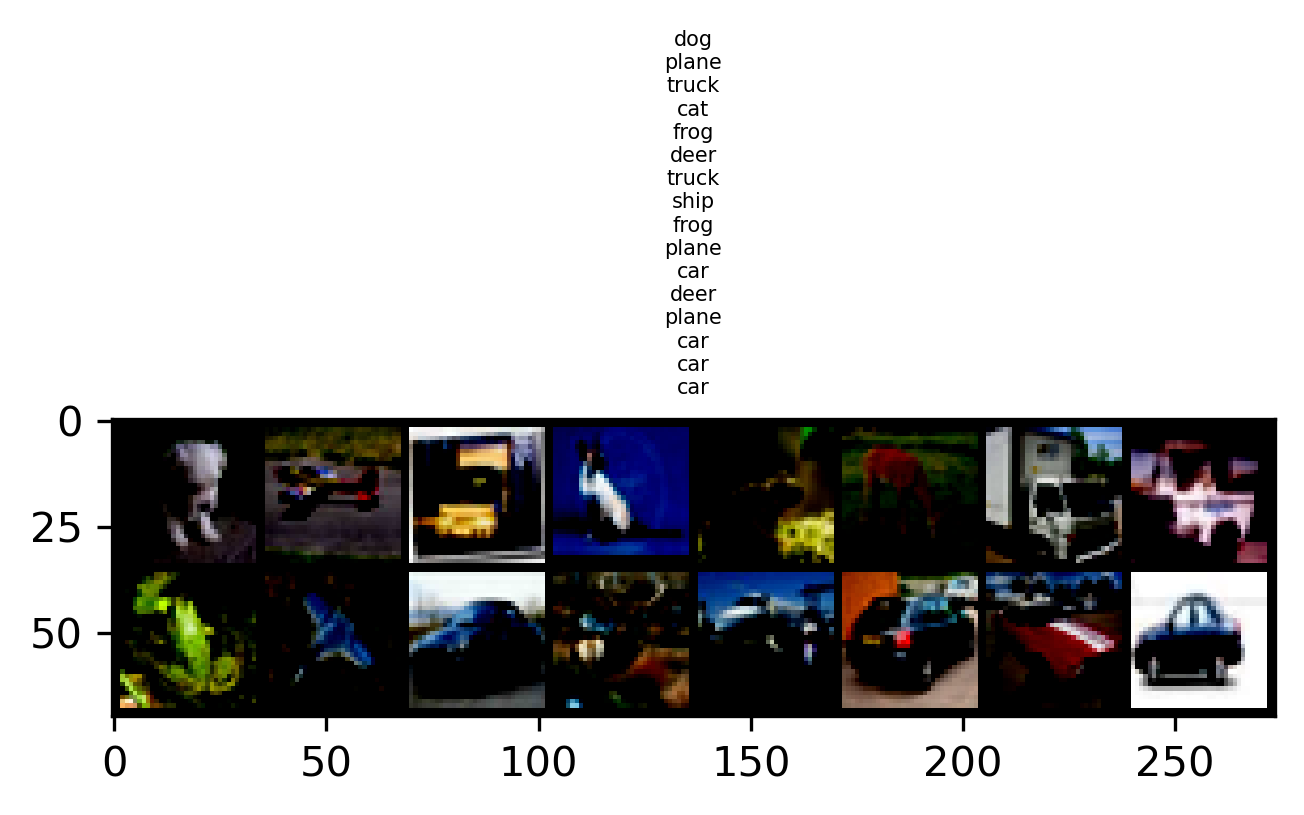

In [6]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=8)
imshow(out, title='\n'.join([class_names[x] for x in classes]))

## A 2-layer Neural Network

We will define 2-fully-connected-layer network using Sequential module. We have two hidden layers: the first one has 100 neurons and the second one has 20 neurons. The last layer is the output that has 10 elements.

Please pay attention that we take images after flattening (line 15 below).

In [7]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32*32*3, 100),
            nn.ReLU(),
            nn.Linear(100, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
        )


    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [8]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=10, bias=True)
  )
)


**Pay attention, in case you change something in the parameters, the data, data loaders, image transform, optimizations and more...you should load the model again so it will start from random weights and not from the last training**.

**You should run again the line** ``model = NeuralNetwork().to(device)``


The next two cells (defining the loss and the training loop) were copied from last exercise.


In [9]:
# If a GPU is available, make the model use it
model = model.to(device)

# For a multi-class problem, you'd usually prefer CrossEntropyLoss()
criterion = nn.CrossEntropyLoss()

# Use Stochastic Gradient Descent as the optimizer, with a learning rate of 0.0001 and momentum
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

num_epochs = 10

In [10]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode.
                model.train()
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    outputs = model(inputs) # apply the model to the inputs. The output is the softmax probability of each class
                    _, preds = torch.max(outputs, 1) #
                    loss = criterion(outputs, labels)

                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer

                # Collect statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                # Adjust the learning rate based on the scheduler
                scheduler.step()

            epoch_loss = running_loss / (len(trainset) if phase == 'train' else len(testset)) # dataset_sizes[phase]
            # epoch_acc = running_corrects.double() / len(trainset) if phase == 'train' else len(testset) # dataset_sizes[phase]
            # to work with mse
            epoch_acc = running_corrects.float() / (len(trainset) if phase == 'train' else len(testset)) # dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Keep the results of the best model so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [12]:
model = train_model(model,
                    dataloaders,
                       criterion,
                       optimizer_ft,
                       exp_lr_scheduler,
                       num_epochs=num_epochs)


Epoch 0/9
----------
train Loss: 1.9961 Acc: 0.2880
val Loss: 1.9014 Acc: 0.3170

Epoch 1/9
----------
train Loss: 1.8476 Acc: 0.3385
val Loss: 1.7966 Acc: 0.3604

Epoch 2/9
----------
train Loss: 1.7608 Acc: 0.3710
val Loss: 1.7228 Acc: 0.3889

Epoch 3/9
----------
train Loss: 1.6999 Acc: 0.3963
val Loss: 1.6700 Acc: 0.4093

Epoch 4/9
----------
train Loss: 1.6533 Acc: 0.4146
val Loss: 1.6315 Acc: 0.4253

Epoch 5/9
----------
train Loss: 1.6142 Acc: 0.4292
val Loss: 1.5965 Acc: 0.4386

Epoch 6/9
----------
train Loss: 1.5789 Acc: 0.4422
val Loss: 1.5674 Acc: 0.4491

Epoch 7/9
----------
train Loss: 1.5536 Acc: 0.4522
val Loss: 1.5613 Acc: 0.4517

Epoch 8/9
----------
train Loss: 1.5496 Acc: 0.4535
val Loss: 1.5586 Acc: 0.4531

Epoch 9/9
----------
train Loss: 1.5464 Acc: 0.4547
val Loss: 1.5558 Acc: 0.4539

Training complete in 8m 26s
Best val Acc: 0.453900


You can continue after you see your model learns something (the training loss is decreasing).

# 2) Losses in Pytorch (10 points)

Now that you managed to run the training loop, let's understand the loss definition. PyTorch provides losses such as cross-entropy loss (`nn.CrossEntropyLoss`) that has just been used. You'll usually see the loss assigned to `criterion`. For classification problems such as CIFAR, we use the softmax function to predict class probabilities. With a softmax output, we need to use cross-entropy as the loss. To actually calculate the loss, we first define the criterion, then pass in it the output of your network and the correct labels.

*Important note!* Look at [the documentation for `nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss),

> This criterion combines `nn.LogSoftmax()` and `nn.NLLLoss()` in one single class.
>
> The input is expected to contain scores for each class.

It means that we need to pass in `nn.CrossEntropyLoss` the raw output of our network into, not the output of the softmax function. This raw output is usually called the *logits* or *scores*. We use the logits because softmax gives you probabilities, which will often be very close to zero or one but floating-point numbers can't accurately represent values near zero or one ([read more here](https://docs.python.org/3/tutorial/floatingpoint.html)). It's usually better to avoid doing calculations with probabilities, and generally we use log-probabilities.

**Exercise:** Change the network above to output the log-softmax and calculate the loss using the negative log-likelihood loss. Note that for `nn.LogSoftmax` and `F.log_softmax` you'll need to set the `dim` keyword argument appropriately. `dim=0` calculates softmax across the rows, so each column sums to 1, while `dim=1` calculates across the columns so each row sums to 1. Think about what you want the output to be and choose `dim` appropriately.


In [13]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32*32*3, 100),
            nn.ReLU(),
            nn.Linear(100, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
        )


    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        lm_output = nn.LogSoftmax(dim=1)(logits)
        return lm_output

In [14]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=10, bias=True)
  )
)


In [15]:
# If a GPU is available, make the model use it
model = model.to(device)

# For a multi-class problem, you'd usually prefer CrossEntropyLoss()
criterion = nn.NLLLoss()

# Use Stochastic Gradient Descent as the optimizer, with a learning rate of 0.0001 and momentum
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

num_epochs = 10

In [16]:
acc_l_tr, acc_l_val, loss_l_tr, loss_l_val =[], [], [], []

def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode.
                model.train()
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    outputs = model(inputs) # apply the model to the inputs. The output is the softmax probability of each class
                    _, preds = torch.max(outputs, 1) #
                    loss = criterion(outputs, labels)

                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer

                # Collect statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                # Adjust the learning rate based on the scheduler
                scheduler.step()

            epoch_loss = running_loss / (len(trainset) if phase == 'train' else len(testset)) # dataset_sizes[phase]
            # epoch_acc = running_corrects.double() / len(trainset) if phase == 'train' else len(testset) # dataset_sizes[phase]
            # to work with mse
            epoch_acc = running_corrects.float() / (len(trainset) if phase == 'train' else len(testset)) # dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
              acc_l_tr.append(epoch_acc)
              loss_l_tr.append(epoch_loss)
            else:
              acc_l_val.append(epoch_acc)
              loss_l_val.append(epoch_loss)

            # Keep the results of the best model so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

model = train_model(model,
                    dataloaders,
                       criterion,
                       optimizer_ft,
                       exp_lr_scheduler,
                       num_epochs=num_epochs)

Epoch 0/9
----------
train Loss: 2.2112 Acc: 0.1983
val Loss: 2.0893 Acc: 0.2760

Epoch 1/9
----------
train Loss: 1.9860 Acc: 0.3093
val Loss: 1.8880 Acc: 0.3376

Epoch 2/9
----------
train Loss: 1.8359 Acc: 0.3529
val Loss: 1.7854 Acc: 0.3665

Epoch 3/9
----------
train Loss: 1.7562 Acc: 0.3780
val Loss: 1.7200 Acc: 0.3942

Epoch 4/9
----------
train Loss: 1.7003 Acc: 0.3975
val Loss: 1.6720 Acc: 0.4087

Epoch 5/9
----------
train Loss: 1.6561 Acc: 0.4149
val Loss: 1.6341 Acc: 0.4254

Epoch 6/9
----------
train Loss: 1.6194 Acc: 0.4277
val Loss: 1.6018 Acc: 0.4348

Epoch 7/9
----------
train Loss: 1.5949 Acc: 0.4372
val Loss: 1.5977 Acc: 0.4372

Epoch 8/9
----------
train Loss: 1.5910 Acc: 0.4385
val Loss: 1.5949 Acc: 0.4374

Epoch 9/9
----------
train Loss: 1.5876 Acc: 0.4396
val Loss: 1.5923 Acc: 0.4403

Training complete in 8m 24s
Best val Acc: 0.440300


# 3) Debug the training (15 points)
With the default parameters we provided above (and without any preprocess or augmentations), you should get a validation accuracy of about 0.2 on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

**Exersice:** Write this visualization here.
(you can copy your solution from last exercies)


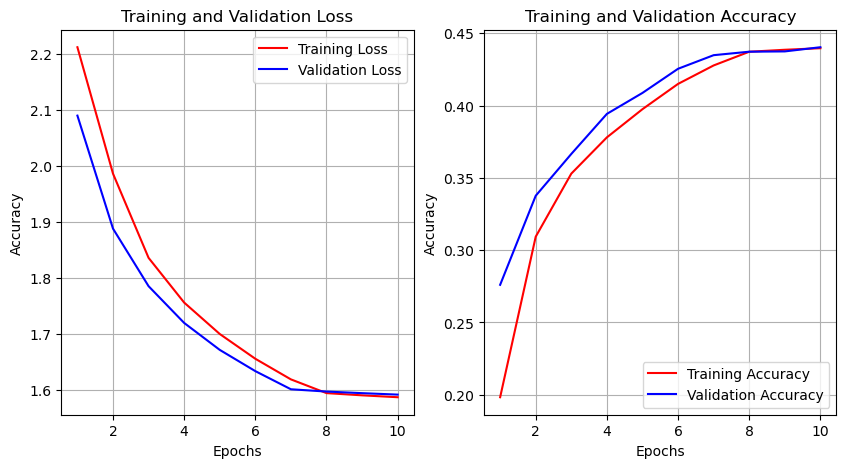

In [17]:
plt.figure(figsize=(10, 5))
epochs = range(1, num_epochs + 1)

plt.subplot(1, 2, 1)
plt.plot(epochs, loss_l_tr, 'r', label='Training Loss')
plt.plot(epochs, loss_l_val, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, [a.cpu().numpy() for a in acc_l_tr], 'r', label='Training Accuracy')
plt.plot(epochs, [a.cpu().numpy() for a in acc_l_val], 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show();

# 4) Tune your hyperparameters (50 points)

**What's wrong?**. Looking at the loss above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy.

**Tuning**. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including *hidden layer size, learning rate, numer of training epochs, and adding l2 or l1 regularization to the cross entropy loss*. You might also consider tuning the learning rate decay, but you should be able to get good performance using the default value.

**Approximate results**. You should be aim to achieve a classification accuracy of greater than 48% on the validation set. Our best network gets over 52% on the validation set.

**Experiment**: You goal in this exercise is to get as good of a result on CIFAR-10 as you can, with a fully-connected Neural Network. Feel free implement your own techniques (e.g. PCA to reduce dimensionality, or adding dropout, or adding features to the solver, etc.).

In [22]:
#################################################################################
# TODO: Tune hyperparameters using the validation set.                          #
#                                                                               #
#                                                                               #

class NeuralNetwork(nn.Module):
    def __init__(self, hls):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32*32*3, hls[0]),
            nn.ReLU(),
            nn.Linear(hls[0], hls[1]),
            nn.ReLU(),
            nn.Linear(hls[1], 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# hidden layer size
hidden_ls = [[100, 20], [150, 30], [180, 40]]

# learning rate
learning_r = [0.001, 0.005, 0.01]
learning_r2 = [0.02, 0.05, 0.1]

# number of training epochs
num_epochs_l = [10, 15, 20, 25]

# adding l2 or l1 regularization to the cross entropy loss
l1_reg = [0, 1e-5]
l2_reg = [0, 1e-5]

In [19]:
#################################################################################
# Your code

# best_model_wts = copy.deepcopy(model.state_dict())
# best_acc = 0.0

# check hidden size layer influence
for hls in hidden_ls[1:]:
    model = NeuralNetwork(hls).to(device)
    print(model)

    # For a multi-class problem, you'd usually prefer CrossEntropyLoss()
    criterion = nn.CrossEntropyLoss()

    # Use Stochastic Gradient Descent as the optimizer, with a learning rate of 0.0001 and momentum
    optimizer_ft = optim.SGD(model.parameters(), lr=learning_r[0], momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

    num_epochs = num_epochs_l[0]

    model = train_model(model,
                    dataloaders,
                    criterion,
                    optimizer_ft,
                    exp_lr_scheduler,
                    num_epochs=num_epochs)    
    
    print()

#################################################################################
#                               END OF YOUR CODE                                #
#################################################################################

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=150, bias=True)
    (1): ReLU()
    (2): Linear(in_features=150, out_features=30, bias=True)
    (3): ReLU()
    (4): Linear(in_features=30, out_features=10, bias=True)
  )
)
Epoch 0/9
----------
train Loss: 2.2151 Acc: 0.2138
val Loss: 2.0839 Acc: 0.2978

Epoch 1/9
----------
train Loss: 1.9537 Acc: 0.3235
val Loss: 1.8509 Acc: 0.3532

Epoch 2/9
----------
train Loss: 1.8012 Acc: 0.3650
val Loss: 1.7536 Acc: 0.3836

Epoch 3/9
----------
train Loss: 1.7251 Acc: 0.3916
val Loss: 1.6941 Acc: 0.4023

Epoch 4/9
----------
train Loss: 1.6718 Acc: 0.4098
val Loss: 1.6472 Acc: 0.4202

Epoch 5/9
----------
train Loss: 1.6287 Acc: 0.4265
val Loss: 1.6113 Acc: 0.4353

Epoch 6/9
----------
train Loss: 1.5912 Acc: 0.4412
val Loss: 1.5810 Acc: 0.4474

Epoch 7/9
----------
train Loss: 1.5654 Acc: 0.4513
val Loss: 1.5735 Acc: 0.4508

Epoch 8/9
----------
train

The models with the increased sizes of the hidden layer don't show better results.

In [20]:
# check learning rate influence
for lr in learning_r[1:]: # we skip lr=0.001 because we already used it in previous tasks
    model = NeuralNetwork(hidden_ls[0]).to(device)
    print(model)

    # For a multi-class problem, you'd usually prefer CrossEntropyLoss()
    criterion = nn.CrossEntropyLoss()

    # Use Stochastic Gradient Descent as the optimizer, with different learning rates 
    optimizer_ft = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

    num_epochs = num_epochs_l[0]

    model = train_model(model,
                    dataloaders,
                    criterion,
                    optimizer_ft,
                    exp_lr_scheduler,
                    num_epochs=num_epochs)    
    
    print()

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=10, bias=True)
  )
)
Epoch 0/9
----------
train Loss: 1.9158 Acc: 0.3112
val Loss: 1.6922 Acc: 0.4018

Epoch 1/9
----------
train Loss: 1.6273 Acc: 0.4218
val Loss: 1.5575 Acc: 0.4531

Epoch 2/9
----------
train Loss: 1.5194 Acc: 0.4631
val Loss: 1.4857 Acc: 0.4800

Epoch 3/9
----------
train Loss: 1.4453 Acc: 0.4917
val Loss: 1.4558 Acc: 0.4929

Epoch 4/9
----------
train Loss: 1.3831 Acc: 0.5134
val Loss: 1.4184 Acc: 0.5019

Epoch 5/9
----------
train Loss: 1.3329 Acc: 0.5319
val Loss: 1.4137 Acc: 0.4999

Epoch 6/9
----------
train Loss: 1.2935 Acc: 0.5449
val Loss: 1.3879 Acc: 0.5122

Epoch 7/9
----------
train Loss: 1.2042 Acc: 0.5798
val Loss: 1.3464 Acc: 0.5253

Epoch 8/9
----------
train

The learning rate equal to 0.01 shows better performance and the accuracy of train and validation datasets is increasing. Let's test the model with even bigger learning rates and number of epoches equal to 20

In [23]:
# check learning rate influence
learning_r2 = [0.02, 0.05, 0.1]

for lr in learning_r2:
    model = NeuralNetwork(hidden_ls[0]).to(device)
    print(model)

    # For a multi-class problem, you'd usually prefer CrossEntropyLoss()
    criterion = nn.CrossEntropyLoss()

    # Use Stochastic Gradient Descent as the optimizer, with different learning rates 
    optimizer_ft = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

    num_epochs = num_epochs_l[2]

    model = train_model(model,
                    dataloaders,
                    criterion,
                    optimizer_ft,
                    exp_lr_scheduler,
                    num_epochs=num_epochs)    
    
    print()

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=10, bias=True)
  )
)
Epoch 0/19
----------


train Loss: 1.7381 Acc: 0.3811
val Loss: 1.5497 Acc: 0.4552

Epoch 1/19
----------
train Loss: 1.5034 Acc: 0.4685
val Loss: 1.4781 Acc: 0.4757

Epoch 2/19
----------
train Loss: 1.4084 Acc: 0.5027
val Loss: 1.4271 Acc: 0.4918

Epoch 3/19
----------
train Loss: 1.3470 Acc: 0.5231
val Loss: 1.4043 Acc: 0.5047

Epoch 4/19
----------
train Loss: 1.3050 Acc: 0.5391
val Loss: 1.4116 Acc: 0.4978

Epoch 5/19
----------
train Loss: 1.2729 Acc: 0.5476
val Loss: 1.4251 Acc: 0.5038

Epoch 6/19
----------
train Loss: 1.2336 Acc: 0.5627
val Loss: 1.4044 Acc: 0.5136

Epoch 7/19
----------
train Loss: 1.0779 Acc: 0.6180
val Loss: 1.3234 Acc: 0.5413

Epoch 8/19
----------
train Loss: 1.0419 Acc: 0.6328
val Loss: 1.3344 Acc: 0.5338

Epoch 9/19
----------
train Loss: 1.0279 Acc: 0.6367
val Loss: 1.3341 Acc: 0.5388

Epoch 10/19
----------
train Loss: 1.0161 Acc: 0.6404
val Loss: 1.3399 Acc: 0.5388

Epoch 11/19
----------
train Loss: 1.0061 Acc: 0.6450
val Loss: 1.3460 Acc: 0.5372

Epoch 12/19
----------
t

So far the best result has been achieved with the learning rate equal to 0.02 on epoch number 12 (accuracy: 0.5406). Now with these parameters we will implement L1 and L2 regularization with $\lambda = 1e-5$

In [24]:
# For a multi-class problem, you'd usually prefer CrossEntropyLoss()
criterion = nn.CrossEntropyLoss()

# Use Stochastic Gradient Descent as the optimizer, with different learning rates 
optimizer_ft = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

num_epochs = num_epochs_l[1]

# def function with regularization
acc_l_tr, acc_l_val, loss_l_tr, loss_l_val =[], [], [], []

def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25, l1_strength=0, l2_strength=0):
    since = time.time()

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode.
                model.train()
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    outputs = model(inputs) # apply the model to the inputs. The output is the softmax probability of each class
                    _, preds = torch.max(outputs, 1) #
                    loss = criterion(outputs, labels)

                    # L1 Regularization
                    if l1_strength > 0:
                        l1_reg_ = torch.tensor(0.).to(device)
                        for param in model.parameters():
                            l1_reg_ += torch.norm(param, 1)
                        loss += l1_strength * l1_reg_

                    # L2 Regularization
                    if l2_strength > 0:
                        l2_reg_ = torch.tensor(0.).to(device)
                        for param in model.parameters():
                            l2_reg_ += torch.norm(param, 2)**2
                        loss += l2_strength * l2_reg_

                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer

                # Collect statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                # Adjust the learning rate based on the scheduler
                scheduler.step()

            epoch_loss = running_loss / (len(trainset) if phase == 'train' else len(testset)) # dataset_sizes[phase]
            # epoch_acc = running_corrects.double() / len(trainset) if phase == 'train' else len(testset) # dataset_sizes[phase]
            # to work with mse
            epoch_acc = running_corrects.float() / (len(trainset) if phase == 'train' else len(testset)) # dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
              acc_l_tr.append(epoch_acc)
              loss_l_tr.append(epoch_loss)
            else:
              acc_l_val.append(epoch_acc)
              loss_l_val.append(epoch_loss)

            # Keep the results of the best model so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

print("With L1 regularization")

model = NeuralNetwork(hidden_ls[0]).to(device)
print(model)

model = train_model(model,
                    dataloaders,
                    criterion,
                    optimizer_ft,
                    exp_lr_scheduler,
                    num_epochs=num_epochs,
                    l1_strength=l1_reg[1])

print("/nWith L2 regularization")

model = NeuralNetwork(hidden_ls[0]).to(device)
print(model)

model = train_model(model,
                    dataloaders,
                    criterion,
                    optimizer_ft,
                    exp_lr_scheduler,
                    num_epochs=num_epochs,
                    l2_strength=l2_reg[1])

With L1 regularization
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=10, bias=True)
  )
)
Epoch 0/14
----------
train Loss: 2.3361 Acc: 0.0998
val Loss: 2.3361 Acc: 0.1010

Epoch 1/14
----------
train Loss: 2.3361 Acc: 0.0998
val Loss: 2.3361 Acc: 0.1010

Epoch 2/14
----------
train Loss: 2.3361 Acc: 0.0998
val Loss: 2.3361 Acc: 0.1010

Epoch 3/14
----------
train Loss: 2.3361 Acc: 0.0998
val Loss: 2.3361 Acc: 0.1010

Epoch 4/14
----------
train Loss: 2.3361 Acc: 0.0998
val Loss: 2.3361 Acc: 0.1010

Epoch 5/14
----------
train Loss: 2.3361 Acc: 0.0998
val Loss: 2.3361 Acc: 0.1010

Epoch 6/14
----------
train Loss: 2.3361 Acc: 0.0998
val Loss: 2.3361 Acc: 0.1010

Epoch 7/14
----------
train Loss: 2.3361 Acc: 0.0998
val Loss: 2.3361 Acc: 0.1

L1 and L2 regularization make our result worse, so we will not use them further.

In [25]:
# model with dropout
class NeuralNetwork(nn.Module):
    def __init__(self, hls):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.25)
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32*32*3, hls[0]),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(hls[0], hls[1]),
            nn.ReLU(),
            nn.Linear(hls[1], 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
model = NeuralNetwork(hidden_ls[0]).to(device)
print(model)

# For a multi-class problem, you'd usually prefer CrossEntropyLoss()
criterion = nn.CrossEntropyLoss()

# Use Stochastic Gradient Descent as the optimizer, with different learning rates 
optimizer_ft = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

num_epochs = num_epochs_l[1] # 15 epochs

model = train_model(model,
                    dataloaders,
                    criterion,
                    optimizer_ft,
                    exp_lr_scheduler,
                    num_epochs=num_epochs)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.25, inplace=False)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=100, out_features=20, bias=True)
    (4): ReLU()
    (5): Linear(in_features=20, out_features=10, bias=True)
  )
)
Epoch 0/14
----------
train Loss: 1.8074 Acc: 0.3536
val Loss: 1.6042 Acc: 0.4258

Epoch 1/14
----------
train Loss: 1.6147 Acc: 0.4243
val Loss: 1.5165 Acc: 0.4559

Epoch 2/14
----------
train Loss: 1.5524 Acc: 0.4467
val Loss: 1.4738 Acc: 0.4758

Epoch 3/14
----------
train Loss: 1.5148 Acc: 0.4629
val Loss: 1.4511 Acc: 0.4792

Epoch 4/14
----------
train Loss: 1.4744 Acc: 0.4774
val Loss: 1.4135 Acc: 0.4934

Epoch 5/14
----------
train Loss: 1.4471 Acc: 0.4852
val Loss: 1.4152 Acc: 0.4943

Epoch 6/14
----------
train Loss: 1.4253 Acc: 0.4934
val Loss: 1.4094 Acc: 0.4916

Epoch 7/14
------


**Conclusion**

The highest validation accuracy achieved was 0.5413. This result was obtained under the following conditions:

- Using the initial model architecture with hidden layer of size [100,20].
- Training for a total of 12 epochs.
- Employing a learning rate of 0.02.
- Not applying L1 or L2 regularization or dropout techniques.

# Interview Question (15 points)

Now that you have trained a Neural Network classifier, you may find that your testing accuracy is lower than the training accuracy. In what ways can we decrease this gap? Select all that apply.
1. Train on a larger dataset.
2. Add more hidden units.
3. Increase the regularization strength.
4. None of the above.

*Your answer*:<br>
1. Train on a larger dataset.
3. Increase the regularization strength.

*Your explanation:*
1. A larger dataset provides more examples and variability, which can improve the model's ability to learn the underlying pattern and reduce overfitting.
3. There are several regularization techniques in the neural network: Early stopping, L1 and L2 regularization, Data augmentation, Addition of noise, Dropout. <br>
Regularization techniques penalize large weights or the total model complexity (dropout), encouraging the model to learn simpler models and thus improving its generalization capabilities. This can effectively reduce the gap between training and testing accuracy by preventing the model from overfitting to the training data.